# **Foundation of Machine Learning Course 2023: COVID Case Data Exploration and Modeling**

## Load Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## Reading in Data

In [2]:
df = pd.read_csv(r"C:\Users\daniel.s.ross\OneDrive - Accenture Federal Services\Foundations of ML\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_-_ARCHIVED.csv")
df.head(5)

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,03/11/2021,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN
1,12/01/2021,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree
2,01/02/2022,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN
3,11/22/2021,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree
4,05/30/2022,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN


## Initial Data Transformation for Regression

We will just look at VA and only the dates with more than zero deaths.

In [3]:
df.describe()

,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death
count,6.006000e+04,3.403400e+04,33962.000000,60060.000000,56534.000000,60060.000000,33273.000000,33273.000000,60060.000000,56566.000000
mean,6.569641e+05,6.527994e+05,107357.455686,1601.409574,267.290197,9351.235648,9015.954498,1093.250293,17.365335,1.825584
std,1.173490e+06,1.077693e+06,157946.539796,5074.263900,1439.172514,14591.369916,10431.915891,1549.192666,43.499174,24.534287
min,0.000000e+00,0.000000e+00,0.000000,-10199.000000,-171804.000000,0.000000,0.000000,0.000000,-352.000000,-2594.000000
25%,1.830325e+04,6.512275e+04,169.250000,3.000000,0.000000,361.000000,1377.000000,0.000000,0.000000,0.000000
50%,2.228415e+05,2.992460e+05,32175.000000,344.000000,1.000000,3241.000000,5193.000000,309.000000,3.000000,0.000000
75%,8.158552e+05,8.426732e+05,150251.250000,1435.000000,175.000000,12353.250000,13720.000000,1691.000000,16.000000,1.000000
max,1.130924e+07,1.045879e+07,850445.000000,319809.000000,171617.000000,95604.000000,71408.000000,7889.000000,1178.000000,2919.000000


In [4]:
today = dt.datetime.now()

def date_to_int(date_in):
    return int(date_in.strftime('%y%m%d'))

date_to_int(today)



230519

In [5]:
# Filter for VA data only
df_va = df[(df['tot_cases']>0) & (df['state']=='VA')]

# Compute death rate
df_va['death_rate'] = df_va.apply(lambda x: x.tot_death/x.tot_cases, axis = 1)

# Convert string data to date date
df_va['date'] = pd.to_datetime(df_va['submission_date'])
df_va['date'] = df_va.apply(lambda x: (x.date - df_va['date'].min()).days, axis = 1)

# Select only date and death rate for modeling
df_feature = df_va[['date','death_rate']]

df_feature.head()

C:\Users\daniel.s.ross\AppData\Local\Temp\ipykernel_24884\1181991368.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_va['death_rate'] = df_va.apply(lambda x: x.tot_death/x.tot_cases, axis = 1)
C:\Users\daniel.s.ross\AppData\Local\Temp\ipykernel_24884\1181991368.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_va['date'] = pd.to_datetime(df_va['submission_date'])
C:\Users\daniel.s.ross\AppData\Local\Temp\ipykernel_24884\1181991368.py:9: SettingWithCopyWarning: 
A value is trying to be set on a c

,date,death_rate
15526,586,0.014830
15546,21,0.024510
15552,863,0.010820
15608,615,0.015189
15690,870,0.010725


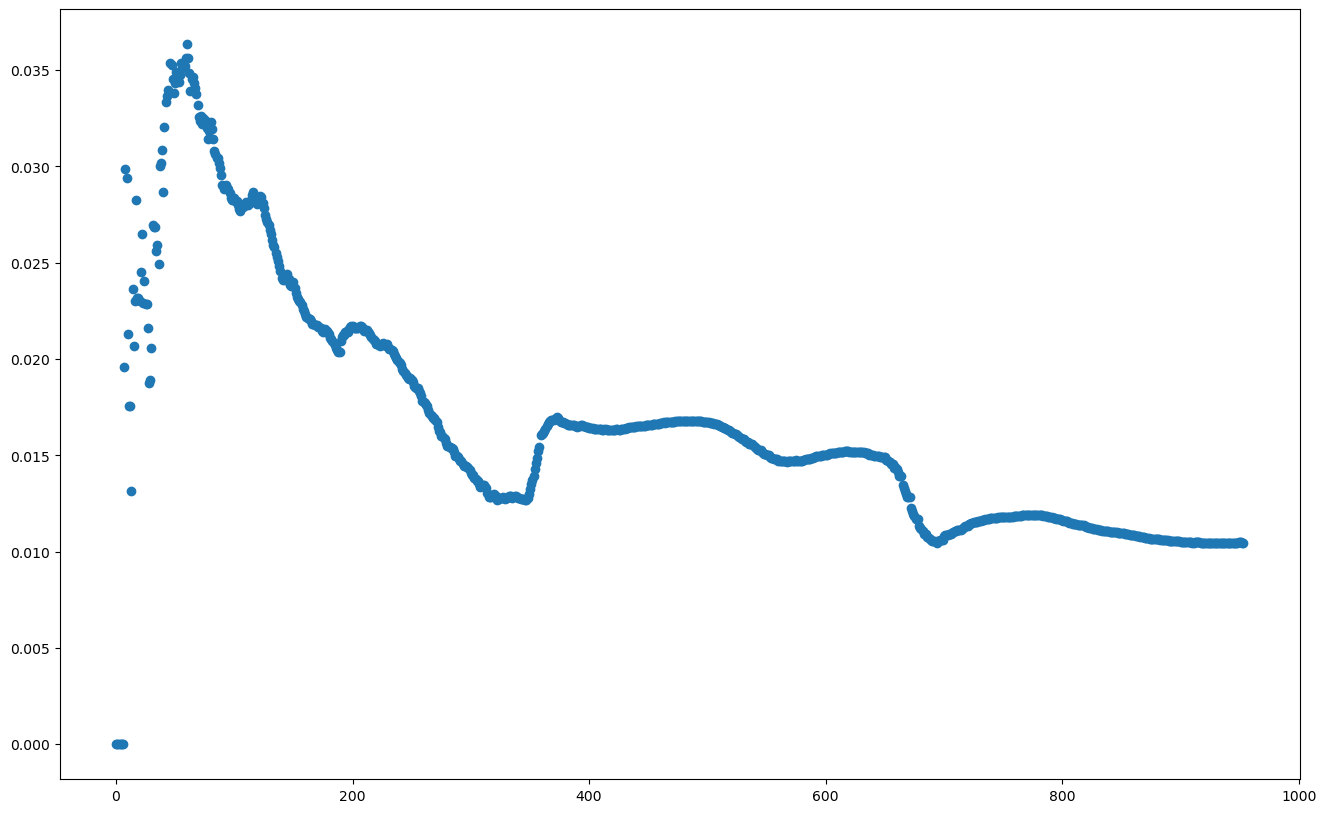

In [6]:
plt.figure(figsize=(16,10))
#plt.plot_date(df_feature['date'], df_feature['death_rate'])
plt.scatter(df_feature['date'], df_feature['death_rate'])

## Train/Validation/Test Split

We want to do an 80/20/20 split. This is a temporal split

In [7]:
len(df_feature)

954

In [8]:
# Sort data by date first
df_feature = df_feature.sort_values(by='date', ascending=True).reset_index(drop=True)

# Split data
df_train = df_feature[:574]
df_test = df_feature[574:764]
df_validate = df_feature[764:]

In [9]:
len(df_train)

574

## Train the Model

For this example, I suggest we try out An autoregressive integrated moving average (ARIMA) model, an XGBOOST model, or another time series model

In [10]:
from numpy import loadtxt
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [11]:
train_x = df_train[['date']]
train_y = df_train[['death_rate']]

test_x = df_test[['date']]
test_y = df_test[['death_rate']]

validate_x = df_validate[['date']]
validate_y = df_validate[['death_rate']]

In [12]:
df_train['date'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [13]:
# Fit model no training data
model = XGBRegressor()
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
# Make predictions for test data

y_pred = model.predict(validate_x)
predictions = [value for value in y_pred]

y_pred_test = model.predict(test_x)
predictions_test = [value for value in y_pred_test]

print(predictions)

[0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765, 0.014948765

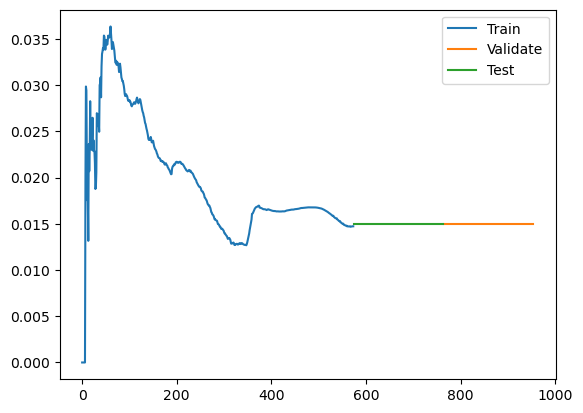

In [15]:
plt.plot(train_x, train_y, label='Train')
plt.plot(validate_x, y_pred, label='Validate')
plt.plot(test_x, y_pred_test, label='Test')
plt.legend()
